In [1]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic
from scipy.optimize import minimize

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

### MCMC
import emcee
# import time
import mcmc as mc

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [3]:
################
### LMC Data ###
################

### Import Data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&(lmc['M_H_ERR']>-90.0)&
                (lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

### LMC Geometry
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)

In [4]:
#############
### MCMC  ###
#############

ms = []
ms_err = []
bs = []
bs_err = []


for i in tqdm_notebook(range(len(elems)),desc='Progress'):
    cln = np.where((lmc[elems[i]]>-100.)&(lmc['SNR']>=100))
    
    rad_cln = radius[cln]
    abund_cln = lmc[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, _ = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        bin_stats_err, _, _ = binned_statistic(rad_cln,abund_cln,
                                               statistic=lambda y: np.median(np.absolute(y-np.median(y))),
                                               bins=bins)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
    
#     print('{}: Slope {:.4f} +/- {:.4f}; Inter {:.4f} +/- {:.4f}'.format(elems[i],np.median(flat_samples[:,0]),
#                                                                         mc.mad(flat_samples[:,0]),
#                                                                         np.median(flat_samples[:,1]),
#                                                                         mc.mad(flat_samples[:,1])))
        ms.append(np.median(flat_samples[:,0]))
        ms_err.append(mc.mad(flat_samples[:,0]))
        bs.append(np.median(flat_samples[:,1]))
        bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        ms.append(-9999.0)
        ms_err.append(-9999.0)
        bs.append(-9999.0)
        bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:47<00:00, 105.17it/s]


In [5]:
for i in range(len(ms)-5):
    print('{}: slope: {:.4f} +/- {:.4f} inter: {:.4f} +/- {:.4f}'.format(elems[i],ms[i],ms_err[i],bs[i],
                                                                         bs_err[i]))

M_H: slope: -0.0416 +/- 0.0239 inter: -0.5888 +/- 0.0821
C_FE: slope: -0.0217 +/- 0.0130 inter: -0.2739 +/- 0.0439
N_FE: slope: -0.0120 +/- 0.0100 inter: 0.1477 +/- 0.0421
O_FE: slope: 0.0026 +/- 0.0042 inter: 0.0241 +/- 0.0143
NA_FE: slope: -0.0041 +/- 0.0188 inter: -0.1727 +/- 0.0553
MG_FE: slope: 0.0071 +/- 0.0066 inter: 0.0823 +/- 0.0230
AL_FE: slope: -0.0117 +/- 0.0121 inter: -0.3128 +/- 0.0406
SI_FE: slope: 0.0040 +/- 0.0060 inter: -0.0107 +/- 0.0197
P_FE: slope: 0.0330 +/- 0.0299 inter: -0.0141 +/- 0.0953
S_FE: slope: 0.0167 +/- 0.0225 inter: 0.1409 +/- 0.0695
K_FE: slope: 0.0214 +/- 0.0113 inter: -0.0600 +/- 0.0318
CA_FE: slope: -0.0013 +/- 0.0039 inter: 0.1053 +/- 0.0134
TI_FE: slope: 0.0201 +/- 0.0048 inter: -0.1331 +/- 0.0137
TIII_FE: slope: 0.0306 +/- 0.0214 inter: -0.1666 +/- 0.0577
V_FE: slope: -0.0035 +/- 0.0112 inter: -0.1040 +/- 0.0356
CR_FE: slope: -0.0063 +/- 0.0101 inter: 0.0624 +/- 0.0302
MN_FE: slope: -0.0250 +/- 0.0051 inter: -0.0162 +/- 0.0131
FE_H: slope: -0.03

In [6]:
elems_dis = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return ms[i]*x+bs[i]
    
    cln = np.where((lmc[elems[i]]>-100)&(lmc['SNR']>=100))
    plug = trendline(radius[cln])
    dis = plug-lmc[elems[i]][cln]
    
    elems_dis.append(dis)

In [7]:
re_ms = []
re_ms_err = []
re_bs = []
re_bs_err = []

prune_fact = 3.
for i in tqdm_notebook(range(len(elems)-5),desc='Progress'):
    cln = np.where((lmc[elems[i]]>-100.)&(lmc['SNR']>=100))
    prune = np.where((lmc[elems[i]]>-prune_fact*mc.mad(elems_dis[i])+
                      np.median(lmc[cln][elems[i]]))&
                     (lmc[elems[i]]<prune_fact*mc.mad(elems_dis[i])+
                      np.median(lmc[cln][elems[i]])))

    rad_cln = radius[prune]
    abund_cln = lmc[elems[i]][prune]
#     endog_err = lmc[elems_err[i]][prune]
    
#     rad_cln = radius[cln]
#     abund_cln = lmc[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
#         bin_stats_err, _, _ = binned_statistic(rad_cln,abund_cln,
#                                                statistic=lambda y: np.median(np.absolute(y-np.median(y))),
#                                                bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
    
#     print('{}: Slope {:.4f} +/- {:.4f}; Inter {:.4f} +/- {:.4f}'.format(elems[i],np.median(flat_samples[:,0]),
#                                                                         mc.mad(flat_samples[:,0]),
#                                                                         np.median(flat_samples[:,1]),
#                                                                         mc.mad(flat_samples[:,1])))
        re_ms.append(np.median(flat_samples[:,0]))
        re_ms_err.append(mc.mad(flat_samples[:,0]))
        re_bs.append(np.median(flat_samples[:,1]))
        re_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_ms.append(-9999.0)
        re_ms_err.append(-9999.0)
        re_bs.append(-9999.0)
        re_bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:52<00:00, 94.87it/s]

In [8]:
for i in range(len(re_ms)):
    print('{}: slope: {:.4f} +/- {:.4f} inter: {:.4f} +/- {:.4f}'.format(elems[i],re_ms[i],re_ms_err[i],re_bs[i],
                                                                         re_bs_err[i]))

M_H: slope: -0.0267 +/- 0.0186 inter: -0.6013 +/- 0.0630
C_FE: slope: -0.0186 +/- 0.0088 inter: -0.2721 +/- 0.0352
N_FE: slope: -0.0106 +/- 0.0063 inter: 0.1194 +/- 0.0254
O_FE: slope: -0.0013 +/- 0.0028 inter: 0.0386 +/- 0.0126
NA_FE: slope: 0.0029 +/- 0.0169 inter: -0.1817 +/- 0.0547
MG_FE: slope: 0.0010 +/- 0.0057 inter: 0.1015 +/- 0.0217
AL_FE: slope: -0.0107 +/- 0.0111 inter: -0.3091 +/- 0.0377
SI_FE: slope: 0.0037 +/- 0.0048 inter: -0.0048 +/- 0.0171
P_FE: slope: 0.0264 +/- 0.0212 inter: 0.0283 +/- 0.0704
S_FE: slope: 0.0095 +/- 0.0220 inter: 0.1491 +/- 0.0696
K_FE: slope: 0.0109 +/- 0.0070 inter: -0.0354 +/- 0.0213
CA_FE: slope: -0.0019 +/- 0.0035 inter: 0.1077 +/- 0.0126
TI_FE: slope: 0.0002 +/- 0.0049 inter: -0.1078 +/- 0.0099
TIII_FE: slope: 0.0322 +/- 0.0105 inter: -0.1901 +/- 0.0220
V_FE: slope: -0.0037 +/- 0.0097 inter: -0.0918 +/- 0.0314
CR_FE: slope: -0.0075 +/- 0.0079 inter: 0.0714 +/- 0.0276
MN_FE: slope: -0.0123 +/- 0.0042 inter: -0.0404 +/- 0.0118
FE_H: slope: -0.022

MLE Method:

M_H: slope: -0.0266 +/- 0.0025 inter: -0.6023 +/- 0.0092

C_FE: slope: -0.0177 +/- 0.0019 inter: -0.2743 +/- 0.0066

N_FE: slope: -0.0096 +/- 0.0016 inter: 0.1177 +/- 0.0063

O_FE: slope: 0.0002 +/- 0.0015 inter: 0.0340 +/- 0.0041

NA_FE: slope: 0.0015 +/- 0.0036 inter: -0.1785 +/- 0.0123

MG_FE: slope: 0.0025 +/- 0.0020 inter: 0.0973 +/- 0.0060

AL_FE: slope: -0.0101 +/- 0.0015 inter: -0.3117 +/- 0.0058

SI_FE: slope: 0.0042 +/- 0.0013 inter: -0.0062 +/- 0.0044

P_FE: slope: 0.0237 +/- 0.0046 inter: 0.0363 +/- 0.0159

S_FE: slope: 0.0091 +/- 0.0029 inter: 0.1513 +/- 0.0097

K_FE: slope: 0.0116 +/- 0.0037 inter: -0.0373 +/- 0.0109

CA_FE: slope: -0.0017 +/- 0.0006 inter: 0.1070 +/- 0.0016

TI_FE: slope: 0.0009 +/- 0.0037 inter: -0.1096 +/- 0.0084

TIII_FE: slope: 0.0287 +/- 0.0061 inter: -0.1774 +/- 0.0198

V_FE: slope: -0.0037 +/- 0.0017 inter: -0.0915 +/- 0.0065

CR_FE: slope: -0.0081 +/- 0.0015 inter: 0.0731 +/- 0.0041

MN_FE: slope: -0.0155 +/- 0.0023 inter: -0.0347 +/- 0.0063

FE_H: slope: -0.0225 +/- 0.0023 inter: -0.6088 +/- 0.0091

CO_FE: slope: -0.0059 +/- 0.0018 inter: -0.1229 +/- 0.0056

NI_FE: slope: -0.0010 +/- 0.0007 inter: -0.1273 +/- 0.0025

CU_FE: slope: 0.0213 +/- 0.0055 inter: 0.0541 +/- 0.0165

<font size='30'>
    <b>
        AGES BINS
    </b>
</font>

In [9]:
# Ages
# ages = fits.getdata('pca_ols_ages.fits')
ages = fits.getdata('TEST_pca_ols_ages.fits')

#####################
### Make Age Bins ###
#####################

young = np.where(ages['AGE']<=np.log10(0.5*10**9))
yless = np.where((ages['AGE']>np.log10(0.5*10**9))&(ages['AGE']<=np.log10(2.0*10**9)))
ymed = np.where((ages['AGE']>np.log10(2.0*10**9))&(ages['AGE']<=np.log10(7*10**9)))
omed = np.where((ages['AGE']>np.log10(7*10**9))&(ages['AGE']<=np.log10(10.5*10**9)))
old = np.where(ages['AGE']>np.log10(10.5*10**9))

lmcyoung = lmc[young]
lmcyless = lmc[yless]
lmcymed = lmc[ymed]
lmcomed = lmc[omed]
lmcold = lmc[old]

In [10]:
##################################
### Age bin initial Trendlines ###
##################################

### young

young_ms = []
young_ms_err = []
young_bs = []
young_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcyoung[elems[i]]>-100.)&(lmcyoung['SNR']>=100))
    rad_cln = radius[young][cln]
    abund_cln = lmcyoung[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        young_ms.append(np.median(flat_samples[:,0]))
        young_ms_err.append(mc.mad(flat_samples[:,0]))
        young_bs.append(np.median(flat_samples[:,1]))
        young_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        young_ms.append(-9999.0)
        young_ms_err.append(-9999.0)
        young_bs.append(-9999.0)
        young_bs_err.append(-9999.0)
    
## yless

yless_ms = []
yless_ms_err = []
yless_bs = []
yless_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcyless[elems[i]]>-100.)&(lmcyless['SNR']>=100))
    rad_cln = radius[yless][cln]
    abund_cln = lmcyless[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        yless_ms.append(np.median(flat_samples[:,0]))
        yless_ms_err.append(mc.mad(flat_samples[:,0]))
        yless_bs.append(np.median(flat_samples[:,1]))
        yless_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        yless_ms.append(-9999.0)
        yless_ms_err.append(-9999.0)
        yless_bs.append(-9999.0)
        yless_bs_err.append(-9999.0)
        
### ymed

ymed_ms = []
ymed_ms_err = []
ymed_bs = []
ymed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcymed[elems[i]]>-100.)&(lmcymed['SNR']>=100))
    rad_cln = radius[ymed][cln]
    abund_cln = lmcymed[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        ymed_ms.append(np.median(flat_samples[:,0]))
        ymed_ms_err.append(mc.mad(flat_samples[:,0]))
        ymed_bs.append(np.median(flat_samples[:,1]))
        ymed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        ymed_ms.append(-9999.0)
        ymed_ms_err.append(-9999.0)
        ymed_bs.append(-9999.0)
        ymed_bs_err.append(-9999.0)
        
### omed

omed_ms = []
omed_ms_err = []
omed_bs = []
omed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcomed[elems[i]]>-100.)&(lmcomed['SNR']>=100))
    rad_cln = radius[omed][cln]
    abund_cln = lmcomed[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        omed_ms.append(np.median(flat_samples[:,0]))
        omed_ms_err.append(mc.mad(flat_samples[:,0]))
        omed_bs.append(np.median(flat_samples[:,1]))
        omed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        omed_ms.append(-9999.0)
        omed_ms_err.append(-9999.0)
        omed_bs.append(-9999.0)
        omed_bs_err.append(-9999.0)

### old

old_ms = []
old_ms_err = []
old_bs = []
old_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcold[elems[i]]>-100.)&(lmcold['SNR']>=100))
    rad_cln = radius[old][cln]
    abund_cln = lmcold[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        old_ms.append(np.median(flat_samples[:,0]))
        old_ms_err.append(mc.mad(flat_samples[:,0]))
        old_bs.append(np.median(flat_samples[:,1]))
        old_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        old_ms.append(-9999.0)
        old_ms_err.append(-9999.0)
        old_bs.append(-9999.0)
        old_bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:52<00:00, 96.15it/s]

100%|██████████| 5000/5000 [00:52<00:00, 96.11it/s]


100%|██████████| 5000/5000 [00:52<00:00, 96.01it/s]


100%|██████████| 5000/5000 [00:52<00:00, 95.43it/s] 

100%|██████████| 5000/5000 [00:55<00:00, 89.35it/s] 

In [11]:
############################################
### Find distances between data and fits ###
############################################

young_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return young_ms[i]*x+young_bs[i]
    
    cln = np.where((lmcyoung[elems[i]]>-100))
    plug = trendline(radius[young][cln])
    dist = plug-lmcyoung[elems[i]][cln]
    
    young_dist.append(dist) 
    
yless_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return yless_ms[i]*x+yless_bs[i]
    
    cln = np.where((lmcyless[elems[i]]>-100))
    plug = trendline(radius[yless][cln])
    dist = plug-lmcyless[elems[i]][cln]
    
    yless_dist.append(dist) 
    
ymed_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return ymed_ms[i]*x+ymed_bs[i]
    
    cln = np.where((lmcymed[elems[i]]>-100))
    plug = trendline(radius[ymed][cln])
    dist = plug-lmcymed[elems[i]][cln]
    
    ymed_dist.append(dist) 
    
omed_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return omed_ms[i]*x+omed_bs[i]
    
    cln = np.where((lmcomed[elems[i]]>-100))
    plug = trendline(radius[omed][cln])
    dist = plug-lmcomed[elems[i]][cln]
    
    omed_dist.append(dist) 
    
old_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return old_ms[i]*x+old_bs[i]
    
    cln = np.where((lmcold[elems[i]]>-100))
    plug = trendline(radius[old][cln])
    dist = plug-lmcold[elems[i]][cln]
    
    old_dist.append(dist)

In [12]:
#################################
### Second Age bin Trendlines ###
#################################

prune_fact = 3.

### young

re_young_ms = []
re_young_ms_err = []
re_young_bs = []
re_young_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcyoung[elems[i]]>-100))
    prune = np.where((lmcyoung[elems[i]]>-prune_fact*mc.mad(young_dist[i])+
                      np.median(lmcyoung[cln][elems[i]]))&
                     (lmcyoung[elems[i]]<prune_fact*mc.mad(young_dist[i])+
                      np.median(lmcyoung[cln][elems[i]])))
    
    rad_cln = radius[young][prune]
    abund_cln = lmcyoung[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        re_young_ms.append(np.median(flat_samples[:,0]))
        re_young_ms_err.append(mc.mad(flat_samples[:,0]))
        re_young_bs.append(np.median(flat_samples[:,1]))
        re_young_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_young_ms.append(-9999.0)
        re_young_ms_err.append(-9999.0)
        re_young_bs.append(-9999.0)
        re_young_bs_err.append(-9999.0)
    
## yless

re_yless_ms = []
re_yless_ms_err = []
re_yless_bs = []
re_yless_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcyless[elems[i]]>-100))
    prune = np.where((lmcyless[elems[i]]>-prune_fact*mc.mad(yless_dist[i])+
                      np.median(lmcyless[cln][elems[i]]))&
                     (lmcyless[elems[i]]<prune_fact*mc.mad(yless_dist[i])+
                      np.median(lmcyless[cln][elems[i]])))
    
    rad_cln = radius[yless][prune]
    abund_cln = lmcyless[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        re_yless_ms.append(np.median(flat_samples[:,0]))
        re_yless_ms_err.append(mc.mad(flat_samples[:,0]))
        re_yless_bs.append(np.median(flat_samples[:,1]))
        re_yless_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_yless_ms.append(-9999.0)
        re_yless_ms_err.append(-9999.0)
        re_yless_bs.append(-9999.0)
        re_yless_bs_err.append(-9999.0)
        
### ymed

re_ymed_ms = []
re_ymed_ms_err = []
re_ymed_bs = []
re_ymed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcymed[elems[i]]>-100))
    prune = np.where((lmcymed[elems[i]]>-prune_fact*mc.mad(ymed_dist[i])+
                      np.median(lmcymed[cln][elems[i]]))&
                     (lmcymed[elems[i]]<prune_fact*mc.mad(ymed_dist[i])+
                      np.median(lmcymed[cln][elems[i]])))
    
    rad_cln = radius[ymed][prune]
    abund_cln = lmcymed[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)

        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        re_ymed_ms.append(np.median(flat_samples[:,0]))
        re_ymed_ms_err.append(mc.mad(flat_samples[:,0]))
        re_ymed_bs.append(np.median(flat_samples[:,1]))
        re_ymed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_ymed_ms.append(-9999.0)
        re_ymed_ms_err.append(-9999.0)
        re_ymed_bs.append(-9999.0)
        re_ymed_bs_err.append(-9999.0)
        
### omed

re_omed_ms = []
re_omed_ms_err = []
re_omed_bs = []
re_omed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcomed[elems[i]]>-100))
    prune = np.where((lmcomed[elems[i]]>-prune_fact*mc.mad(omed_dist[i])+
                      np.median(lmcomed[cln][elems[i]]))&
                     (lmcomed[elems[i]]<prune_fact*mc.mad(omed_dist[i])+
                      np.median(lmcomed[cln][elems[i]])))
    
    rad_cln = radius[omed][prune]
    abund_cln = lmcomed[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
    
        re_omed_ms.append(np.median(flat_samples[:,0]))
        re_omed_ms_err.append(mc.mad(flat_samples[:,0]))
        re_omed_bs.append(np.median(flat_samples[:,1]))
        re_omed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_omed_ms.append(-9999.0)
        re_omed_ms_err.append(-9999.0)
        re_omed_bs.append(-9999.0)
        re_omed_bs_err.append(-9999.0)

### old

re_old_ms = []
re_old_ms_err = []
re_old_bs = []
re_old_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcold[elems[i]]>-100))
    prune = np.where((lmcold[elems[i]]>-prune_fact*mc.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]]))&
                     (lmcold[elems[i]]<prune_fact*mc.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]])))
    
    
    rad_cln = radius[old][prune]
    abund_cln = lmcold[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        re_old_ms.append(np.median(flat_samples[:,0]))
        re_old_ms_err.append(mc.mad(flat_samples[:,0]))
        re_old_bs.append(np.median(flat_samples[:,1]))
        re_old_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_old_ms.append(-9999.0)
        re_old_ms_err.append(-9999.0)
        re_old_bs.append(-9999.0)
        re_old_bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:53<00:00, 92.65it/s] 


100%|██████████| 5000/5000 [00:15<00:00, 317.24it/s]

100%|██████████| 5000/5000 [00:16<00:00, 309.45it/s]


100%|██████████| 5000/5000 [00:16<00:00, 299.92it/s]

100%|██████████| 5000/5000 [00:16<00:00, 298.31it/s]

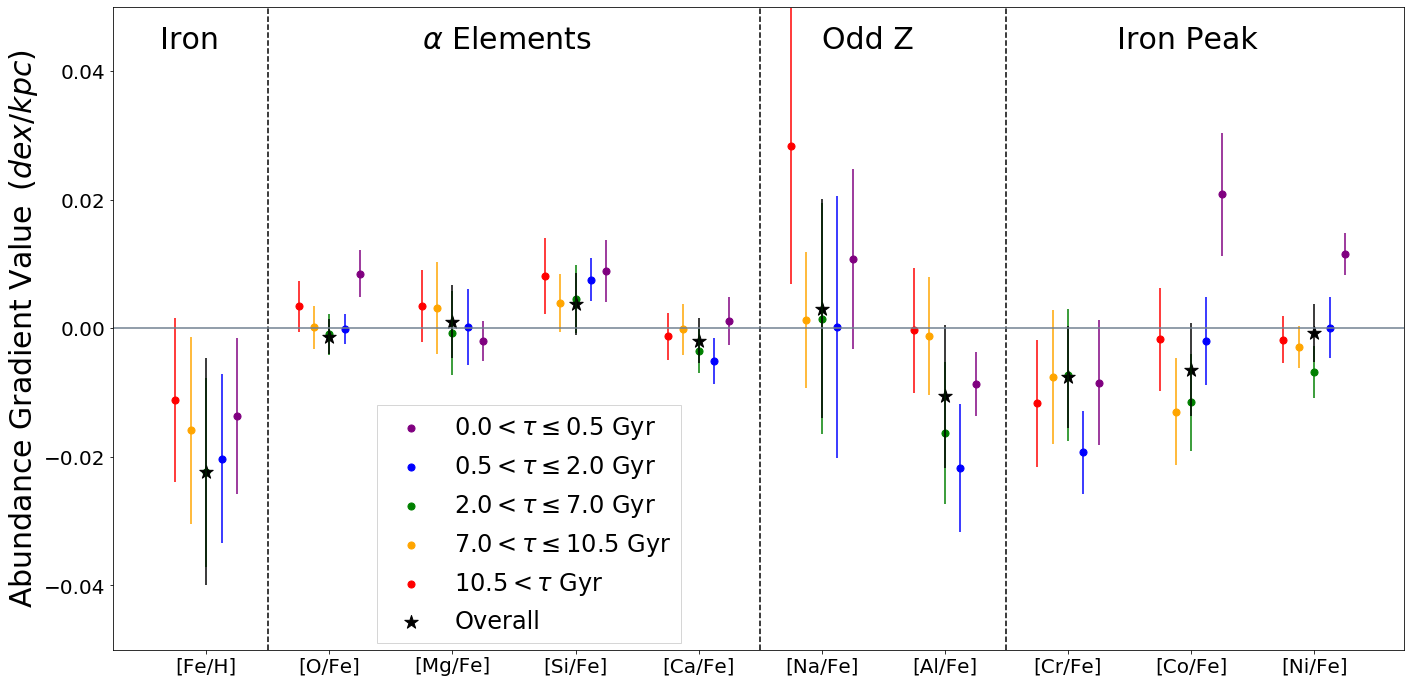

In [12]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_young = []
good_yless = []
good_ymed = []
good_omed = []
good_old = []
good_over = []

err_young = []
err_yless = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

for i in idx:
    good_young.append(re_young_ms[i])
    good_yless.append(re_yless_ms[i])
    good_ymed.append(re_ymed_ms[i])
    good_omed.append(re_omed_ms[i])
    good_old.append(re_old_ms[i])
    good_over.append(re_ms[i])
    
    err_young.append(re_young_ms_err[i])
    err_yless.append(re_yless_ms_err[i])
    err_ymed.append(re_ymed_ms_err[i])
    err_omed.append(re_omed_ms_err[i])
    err_old.append(re_old_ms_err[i])
    err_over.append(re_ms_err[i])

matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_young,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_young,yerr=err_young,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_yless,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_yless,yerr=err_yless,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0435,'Iron',fontsize=30)
plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.0435,'Odd Z',fontsize=30)
plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
plt.tight_layout()
plt.savefig('MCMCgradientSummaryplot.pdf',bbox_inches='tight')
plt.show()

In [13]:
###############################################
### Create Fits File with All the Gradients ###
###############################################

### OVERALL
over_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
over_grad = fits.Column(name='GRAD',array=np.asarray(re_ms),format='D')
over_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_ms_err),format='D')
over_inter = fits.Column(name='INTER',array=np.asarray(re_bs),format='D')
over_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_bs_err),format='D')

over_hdu = fits.BinTableHDU.from_columns([over_elems, over_grad, over_grad_err, over_inter, over_inter_err])

### YOUNG
young_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
young_grad = fits.Column(name='GRAD',array=np.asarray(re_young_ms),format='D')
young_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_young_ms_err),format='D')
young_inter = fits.Column(name='INTER',array=np.asarray(re_bs),format='D')
young_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_young_bs_err),format='D')

young_hdu = fits.BinTableHDU.from_columns([young_elems, young_grad, young_grad_err, young_inter, young_inter_err])

### YLESS
yless_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
yless_grad = fits.Column(name='GRAD',array=np.asarray(re_yless_ms),format='D')
yless_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_yless_ms_err),format='D')
yless_inter = fits.Column(name='INTER',array=np.asarray(re_bs),format='D')
yless_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_yless_bs_err),format='D')

yless_hdu = fits.BinTableHDU.from_columns([yless_elems, yless_grad, yless_grad_err, yless_inter, yless_inter_err])

### YMED
ymed_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
ymed_grad = fits.Column(name='GRAD',array=np.asarray(re_ymed_ms),format='D')
ymed_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_ymed_ms_err),format='D')
ymed_inter = fits.Column(name='INTER',array=np.asarray(re_bs),format='D')
ymed_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_ymed_bs_err),format='D')

ymed_hdu = fits.BinTableHDU.from_columns([ymed_elems, ymed_grad, ymed_grad_err, ymed_inter, ymed_inter_err])

### OMED
omed_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
omed_grad = fits.Column(name='GRAD',array=np.asarray(re_omed_ms),format='D')
omed_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_omed_ms_err),format='D')
omed_inter = fits.Column(name='INTER',array=np.asarray(re_omed_bs),format='D')
omed_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_omed_bs_err),format='D')

omed_hdu = fits.BinTableHDU.from_columns([omed_elems, omed_grad, omed_grad_err, omed_inter, omed_inter_err])

### OLD
old_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
old_grad = fits.Column(name='GRAD',array=np.asarray(re_old_ms),format='D')
old_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_old_ms_err),format='D')
old_inter = fits.Column(name='INTER',array=np.asarray(re_old_bs),format='D')
old_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_old_bs_err),format='D')

old_hdu = fits.BinTableHDU.from_columns([old_elems, old_grad, old_grad_err, old_inter, old_inter_err])

hdu1 = fits.HDUList([over_hdu, young_hdu, yless_hdu, ymed_hdu, omed_hdu, old_hdu])
hdu1.writeto('mcmc_lmc_grads.fits',output_verify='ignore',overwrite=True)

In [14]:
test = fits.getdata('mcmc_lmc_grads.fits',5)
test

FITS_rec([('M_H', -1.25712203e-02, 0.01419071, -6.95550922e-01, 0.04887225),
          ('C_Fe', -9.60679333e-03, 0.0078593 , -3.39836863e-01, 0.02690408),
          ('N_Fe', -3.93862059e-03, 0.00595675,  8.82830637e-02, 0.02160935),
          ('O_Fe',  3.39826610e-03, 0.00401012,  1.25709197e-02, 0.01404691),
          ('Na_Fe',  2.85479701e-02, 0.02140144, -3.03400909e-01, 0.0743138 ),
          ('Mg_Fe',  3.40699343e-03, 0.00561861,  9.90622634e-02, 0.02099645),
          ('Al_Fe', -2.41295038e-04, 0.00970198, -3.80413209e-01, 0.0324257 ),
          ('Si_Fe',  8.17414573e-03, 0.00588489, -3.87618226e-02, 0.02018378),
          ('P_Fe',  3.15997517e-02, 0.03292587, -2.39712793e-02, 0.11535679),
          ('S_Fe',  6.95920794e-03, 0.02512487,  1.54593427e-01, 0.08412   ),
          ('K_Fe', -4.90644806e-05, 0.00067171, -9.99999030e+03, 0.00071528),
          ('Ca_Fe', -1.27508509e-03, 0.00368686,  1.15451858e-01, 0.01211528),
          ('Ti_Fe', -9.47928162e-02, 0.13065731,  3.82648512

In [15]:
lmc.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '39A'
    name = 'ASPCAP_ID'; format = '56A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '105A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '18A'
    name